# Food Classification using EfficentNet B7

## Dataset : [UEC Food-100](http://foodcam.mobi/dataset100.html)

In [1]:
data_dir = '/kaggle/input/uecfood100/UECFOOD100/'

In [2]:
import os
dirNames = os.listdir(data_dir)

for dirName in dirNames:
    if 'txt' in dirName:
        print(dirName)
        dirNames.remove(dirName)
        
print(dirNames)
print(len(dirNames))

category_ja_sjis.txt
multiple_food.txt
category_ja_euc.txt
category.txt
category_ja_utf8.txt
README.txt
['1', '19', '75', '33', '28', '74', '12', '39', '97', '88', '8', '68', '72', '66', '98', '94', '99', '36', '54', '51', '91', '25', '3', '2', '10', '52', '67', '41', '6', '47', '65', '82', '24', '13', '90', '96', '92', '78', '73', '64', '62', '63', '17', '14', '50', '27', '70', '100', '84', '81', '44', '87', '53', '76', '11', '95', '18', '57', '60', '9', '43', '20', '5', '35', '34', '71', '45', '79', '56', '32', '38', '55', '22', '31', '48', '93', '46', '30', '40', '26', '59', '61', '83', '15', '58', '4', '16', '7', '77', '89', '37', '80', '21', '85', '29', '49', '86', '69', '23', '42']
100


### get labels from category.txt

In [3]:
import pandas as pd
df = pd.read_csv(data_dir+'category.txt', sep='\t')
print(df)

labels = df['name'].tolist()

     id                     name
0     1                     rice
1     2             eels on rice
2     3                    pilaf
3     4  chicken-'n'-egg on rice
4     5      pork cutlet on rice
..  ...                      ...
95   96          dipping noodles
96   97                  hot dog
97   98             french fries
98   99               mixed rice
99  100            goya chanpuru

[100 rows x 2 columns]


In [4]:
trainFiles = []
trainClasses = []

for dirName in dirNames:
    for file in os.listdir(data_dir+dirName):
        trainFiles.append(data_dir+dirName+"/"+file)
        trainClasses.append(dirName)

print(len(trainFiles), len(trainClasses))

14461 14461


### display image of a training data

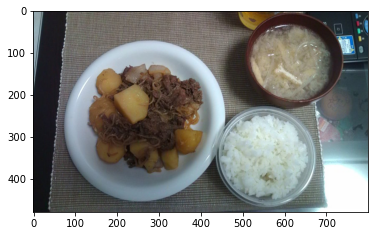

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(mpimg.imread(trainFiles[0]))

## Dataset Equilibre 

In [6]:
from collections import Counter
import seaborn as sns
sns.set_style("whitegrid")

def plot_equilibre(categories, counts):

    plt.figure(figsize=(12, 8))

    sns_bar = sns.barplot(x=categories, y=counts)
    sns_bar.set_xticklabels(categories, rotation=45)
    plt.title('Equilibre of Training Dataset')
    plt.show()

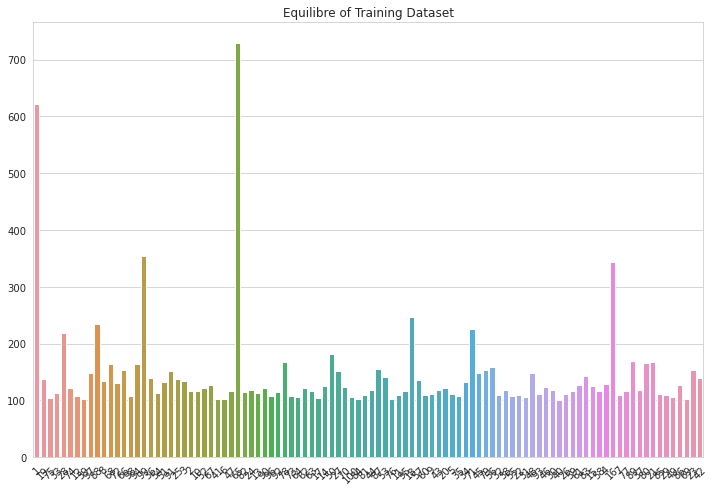

In [7]:
categories = dirNames
counts = []
[counts.append(trainClasses.count(dirName)) for dirName in dirNames]

plot_equilibre(categories, counts)

### split dataset to train/val/test

In [8]:
!pip install split-folders

In [9]:
import splitfolders
splitfolders.ratio('/kaggle/input/uecfood100/UECFOOD100', output='dataset', seed=1234, ratio=(0.8, 0.1, 0.1) )

Copying files: 14461 files [00:48, 297.28 files/s]


## Data Augmentation

In [10]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [11]:
target_size=(224,224)
batch_size = 16

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 11431 images belonging to 100 classes.


In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    'dataset/val',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 1392 images belonging to 100 classes.


In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,     
    class_mode='categorical')

Found 1538 images belonging to 100 classes.


## Build Model

In [15]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.layers import Input, BatchNormalization, Activation, LeakyReLU, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [17]:
num_classes = 100
input_shape = (224,224,3)

In [18]:
# load EfficientNetB7 model with imagenet parameteres
base_model = efn.EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)

258441216/258434480 [==============================] - 7s 0us/step


In [19]:
# freeze the base model (for transfer learning)
base_model.trainable = False

In [20]:
# add two FC layers (with L2 regularization)
x = base_model.output
x = GlobalAveragePooling2D()(x) #2560
#x = BatchNormalization()(x)

#x = Dense(512, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x = Dense(512)(x)
#x = Dropout(0.2)(x)

# Output layer
out = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

__________________________________________________________________________________________________
block6g_se_reshape (Reshape)    (None, 1, 1, 2304)   0           block6g_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6g_se_reduce (Conv2D)      (None, 1, 1, 96)     221280      block6g_se_reshape[0][0]         
__________________________________________________________________________________________________
block6g_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block6g_se_reduce[0][0]          
__________________________________________________________________________________________________
block6g_se_excite (Multiply)    (None, 7, 7, 2304)   0           block6g_activation[0][0]         
                                                                 block6g_se_expand[0][0]          
__________________________________________________________________________________________________
block6g_pr

In [21]:
# Compile Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
## set Checkpoint : save best only, verbose on
#checkpoint = ModelCheckpoint("food100_classification.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1)

## Train Model

In [23]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 50

In [ ]:
# Train Model
history = model.fit_generator(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID) #, callbacks=[checkpoint])

Epoch 1/5
714/714 [==============================] - 228s 320ms/step - loss: 3.5356 - accuracy: 0.2406 - val_loss: 2.2475 - val_accuracy: 0.4231
Epoch 2/5
714/714 [==============================] - 216s 302ms/step - loss: 2.9086 - accuracy: 0.3405 - val_loss: 2.0986 - val_accuracy: 0.4777
Epoch 3/5
134/714 [====>.........................] - ETA: 2:39 - loss: 2.5947 - accuracy: 0.3913

## Save Model

In [ ]:
## Save Model
save_model(model, 'food100_efficientnetB7.h5')

In [ ]:
## load best model weights if using callback (save-best-only)
#model.load_weights("food100_classification.hdf5")

## Evaluate Model

In [ ]:
score = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print(score)

## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predY=model.predict_generator(test_generator)
y_pred = np.argmax(predY,axis=1)
#y_label= [labels[k] for k in y_pred]
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

### report confusion matrix

In [ ]:
print(classification_report(y_actual, y_pred, target_names=labels))